# Self-Driving Car Engineer Nanodegree

## Computer Vision

## Project: Advanced Lane Finding

### Step 0: Declare and import dependencies on modules. Also declare global variables

In [313]:
#Declare dependencies on python modules here
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [414]:
#Declare global variables used here
calibration_images_path = "camera_cal/calibration*.jpg"
distorted_images_path = "distorted_images/distorted*.jpg"
test_images_path = "test_images/*.jpg"
#Since there are 6 object points along rows and 9 object points along columns
num_object_points = (9, 6)
output_folder_path = "output_images/"
#Initialize camera calibration coefficients
camera_cal_coeff = {
    "mtx": 0,
    "dist": 0
}
#Declare and define source weights to be multiplied with imagexsize and imageysize respectively while taking a transform
perspective_src_weights = np.float32([[0.1758, 0.9722], [0.4336, 0.6597], [0.5781, 0.6597], [0.8906, 0.9722]])
#perspective_src_weights = np.float32([[0.1641, 0.9722], [0.4102, 0.6597], [0.5625, 0.6597], [0.875, 0.9722]])
#Declare and define destination weights to be multiplied with imagexsize and imageysize respectively while taking a transform
perspective_dst_weights = np.float32([[0.15625, 1], [0.15625, 0.1389], [0.8203, 0.1389], [0.8203, 1]])
#Set the number of sliding windows
nb_sliding_windows = 10
# Set the width of the windows +/- margin
sliding_window_margin = 50

### Step 1: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

#### Steps to follow:
1. Read calibration images using glob API
2. Create object points(3D array) for one image, this will be same for all other images
3. Detect image points in each calibration image
4. Add object points and image points of particular image to object points and image points array respectively
5. Calculate camera matrix and distortion coefficients

In [315]:
def get_images(path):
    images = glob.glob(path)
    return images
images = get_images(calibration_images_path)
# print(images)
# plt.imshow(cv2.imread(images[0]))
# plt.show()

In [316]:
def calculate_camera_calibration(draw_corners=False):
    images = get_images(calibration_images_path)
    obj_points = []
    img_points = []
    current_obj_point = np.zeros((num_object_points[1]*num_object_points[0], 3), np.float32)
    current_obj_point[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    for image_name in images:
        image = cv2.imread(image_name)
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(image_gray, num_object_points, None)
        
        if ret == True:
            current_img_point = corners
            obj_points.append(current_obj_point)
            img_points.append(current_img_point)
            
            if (draw_corners): 
                cv2.drawChessboardCorners(image, num_object_points, corners, ret)
                plt.imshow(image)
                plt.show()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, image_gray.shape[::-1], None, None)
    return (mtx, dist)
#print(calculate_camera_calibration(draw_corners=False))
#camera_cal_coeff["mtx"], camera_cal_coeff["dist"] = calculate_camera_calibration()

### Step 2: Apply a distortion correction to raw images

#### Steps to follow:
1. Read distorted.jpg image
2. Apply distortion correction
3. Save undistorted image

In [377]:
def undistort(img, mtx, dist, img_file_name="distorted", write_output=False):
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    if (write_output):
        cv2.imwrite(output_folder_path + img_file_name.split(".", -1)[0] + "-corrected." + img_file_name.split(".", -1)[1], undist_image)
    return undist_image
# image_path = get_images(distorted_images_path)[0]
# distorted_image = cv2.imread(image_path)
# plt.imshow(distorted_image)
# plt.show()
# distortion_corrected_image = undistort(distorted_image, \
#                                        camera_cal_coeff["mtx"], \
#                                        camera_cal_coeff["dist"], \
#                                        img_file_name=image_path.replace("\\", "/").split("/")[1], \
#                                        write_output=True)
# plt.imshow(distortion_corrected_image)
# plt.show()

### Step 3: Use color transforms, gradients, etc., to create a thresholded binary image

#### Utility method to crop image to extract the region where lane lines are most likely seen

In [318]:
def crop_image(image, ignore_mask_color=255):
    mask = np.zeros_like(image)
    xsize, ysize = image.shape[1], image.shape[0]
    vertices = ((0.1565*xsize, 0.92*ysize), (xsize/2, 0.4867*ysize), (0.85*xsize, 0.92*ysize))
    vertexArr = []
    for vertex in vertices:
        vertexArr.append((vertex[0], vertex[1]))
    vertexArr = np.array([vertexArr], dtype=np.int32)
    
    cv2.fillPoly(mask, vertexArr, (ignore_mask_color))
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image
# image = cv2.cvtColor(cv2.imread(get_images(test_images_path)[0]), cv2.COLOR_BGR2GRAY)
# masked_image = crop_image(image)
# plt.imshow(masked_image, cmap="gray")
# plt.show()

#### Utility method to merge binary characteristics of two or more images

In [319]:
def merge_binary_images(imgArr):
    merged_image = np.zeros_like(imgArr[0])
    for image in imgArr:
        merged_image[(image == 1)] = 1
    return merged_image

#### Obtain gradient thresholded image with respect to 'x'/'y' orient

In [320]:
def sobel_threshold(img, sobel_kernel=3, orient="x", thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output
# image = cv2.imread(get_images(test_images_path)[7])
# gradx = sobel_threshold(image, sobel_kernel=11, orient="x", thresh=(40, 150))
# grady = sobel_threshold(image, sobel_kernel=11, orient="y", thresh=(40, 150))
# merged = merge_binary_images([gradx, grady])
# plt.imshow(image)
# plt.show()
# plt.imshow(gradx, cmap="gray")
# plt.show()
# plt.imshow(grady, cmap="gray")
# plt.show()
# plt.imshow(merged, cmap="gray")
# plt.show()

#### Obtain magnitude thresholded image from sobel derivatives

In [321]:
def magnitude_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag))
    binary_output = np.zeros_like(scaled_gradmag)
    binary_output[(scaled_gradmag >= thresh[0]) & (scaled_gradmag <= thresh[1])] = 1
    return binary_output
# image = cv2.imread(get_images(test_images_path)[5])
# mag = magnitude_threshold(image, sobel_kernel=11, thresh=(50, 150))
# plt.imshow(image)
# plt.show()
# plt.imshow(mag, cmap="gray")
# plt.show()

#### Obtain magnitude thresholded image from sobel derivatives

In [322]:
def direction_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx_abs = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely_abs = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    graddir = np.arctan2(sobely_abs, sobelx_abs)
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    return binary_output
# image = cv2.imread(get_images(test_images_path)[0])
# dir = direction_threshold(image, sobel_kernel=7, thresh=(0.8, 1.3))
# plt.imshow(image)
# plt.show()
# plt.imshow(dir, cmap="gray")
# plt.show()

#### Obtained combined image from applied gradient thresholds

In [323]:
def apply_grad_threshold(img):
    gradx = sobel_threshold(image, sobel_kernel=11, orient="x", thresh=(40, 150))
    #grady = sobel_threshold(image, sobel_kernel=11, orient="y", thresh=(40, 150))
    mag = magnitude_threshold(image, sobel_kernel=11, thresh=(50, 150))
    #dir = direction_threshold(image, sobel_kernel=11, thresh=(0.8, 1.3))
    #merged_grad_image = merge_binary_images([gradx, grady, mag, dir])
    #merged_grad_image = merge_binary_images([gradx, grady, mag])
    merged_grad_image = merge_binary_images([gradx, mag])
    return merged_grad_image
# image = cv2.imread(get_images(test_images_path)[0])
# merged_grad_image = crop_image(apply_grad_threshold(image))
# plt.imshow(image)
# plt.show()
# plt.imshow(merged_grad_image, cmap="gray")
# plt.show()

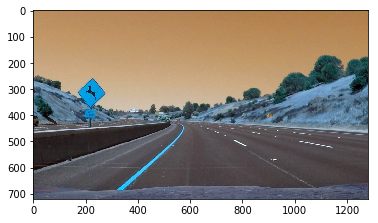

([250, 650], [450, 400], [750, 400], [1150, 650])

In [324]:
image = cv2.imread(get_images(test_images_path)[3])
plt.imshow(image)
plt.show()
# hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
# h, l, s = hls[:,:,0], hls[:,:,1], hls[:,:,2]
# plt.imshow(h)
# plt.show()
# plt.imshow(l)
# plt.show()
# plt.imshow(s)
# plt.show()
[250, 650],[450, 400], [750, 400], [1150, 650]

#### Apply color threshold to image. Method expects 8-bit image (Either of R,G,B,H,L,S channels)

In [325]:
def apply_color_threshold(img):
    r_thresh = (220, 255)
    s_thresh = (160, 255)
    l_thresh = (160, 255)
    r_img = img[:,:,2]
    r_thresholded = np.zeros_like(r_img)
    r_thresholded[(r_img >= r_thresh[0]) & (r_img <= r_thresh[1])] = 1
#     plt.imshow(r_thresholded, cmap="gray")
#     plt.show()
    
    s_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    s_thresholded = np.zeros_like(s_img)
    s_thresholded[(s_img >= s_thresh[0]) & (s_img <= s_thresh[1])] = 1
#     plt.imshow(s_thresholded, cmap="gray")
#     plt.show()
    
#     l_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
#     l_thresholded = np.zeros_like(l_img)
#     l_thresholded[(l_img >= l_thresh[0]) & (l_img <= l_thresh[1])] = 1
#     plt.imshow(l_thresholded, cmap="gray")
#     plt.show()
    
    combined_img = cv2.bitwise_and(r_thresholded, s_thresholded)
#     combined_img = np.zeros_like(s_thresholded)
#     combined_img[(r_thresholded == 1) | (s_thresholded == 1)] = 1
    return combined_img
image = cv2.imread(get_images(test_images_path)[6])
# r_img, g_img, b_img = image[:,:,2], image[:,:,1], image[:,:,0]
# hls_img = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
# h_img, l_img, s_img = hls_img[:,:,0], hls_img[:,:,1], hls_img[:,:,2]
# r_thresholded = apply_color_threshold(r_img, thresh=(175, 255))
# s_thresholded = apply_color_threshold(s_img, thresh=(100, 255))
# l_thresholded = apply_color_threshold(l_img, thresh=(150, 255))
# l_and_s = np.zeros_like(l_thresholded)
# l_and_s[(s_thresholded == 1) | (l_thresholded == 1)] = 1
# combined_all = cv2.bitwise_and(r_thresholded, s_thresholded)
# plt.imshow(image)
# plt.show()
# # plt.imshow(r_thresholded, cmap="gray")
# # plt.show()
# plt.imshow(s_thresholded, cmap="gray")
# plt.show()
# # plt.imshow(l_thresholded, cmap="gray")
# # plt.show()
# # plt.imshow(l_and_s, cmap="gray")
# # plt.show()
# # plt.imshow(combined, cmap="gray")
# # plt.show()
color_thresholded = apply_color_threshold(image)

#### Combine color and gradient thresholds to obtain threshloded image with lane lines detected

In [392]:
def detect_lane_lines(img):
    grad_thresholded = apply_grad_threshold(img)
#     plt.imshow(grad_thresholded, cmap="gray")
#     plt.show()
    color_thresholded = apply_color_threshold(img)
#     plt.imshow(color_thresholded, cmap="gray")
#     plt.show()
    color_and_grad = np.zeros_like(color_thresholded)
    color_and_grad[(grad_thresholded == 1) | (color_thresholded == 1)] = 1
    return color_and_grad
# image = cv2.imread(get_images(test_images_path)[6])
# lane_image = detect_lane_lines(image)
# plt.imshow(image)
# plt.show()
# plt.imshow(lane_image, cmap="gray")
# plt.show()

### Step 4: Apply a perspective transform to rectify binary image ("birds-eye view")

#### Apply perspective transform based on selected trapezoidal points in original image

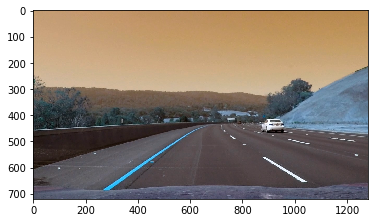

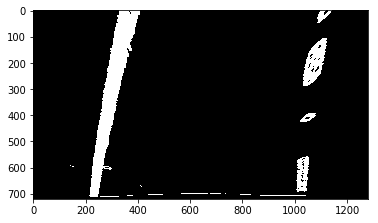

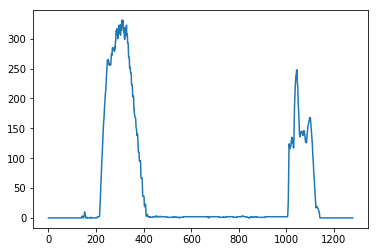

In [403]:
def apply_perspective_transform(img):
    img_size = img.shape
    src = np.concatenate(([perspective_src_weights.T[0]*img_size[1]], [perspective_src_weights.T[1]*img_size[0]]), axis=0).T
    dst = np.concatenate(([perspective_dst_weights.T[0]*img_size[1]], [perspective_dst_weights.T[1]*img_size[0]]), axis=0).T
    perspective_M = cv2.getPerspectiveTransform(src, dst)
    perspective_Minv = cv2.getPerspectiveTransform(dst, src)
    warped_img = cv2.warpPerspective(img, perspective_M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
    return (warped_img, perspective_M, perspective_Minv)
image = cv2.imread(get_images(test_images_path)[4])
#     src = np.float32([[225, 700], [555, 475], [740, 475], [1140, 700]])
#     dst = np.float32([[100, 720], [100, 100], [1100, 100], [1100, 720]])
warped_img = apply_perspective_transform(detect_lane_lines(image))[0]
plt.imshow(image)
plt.show()
plt.imshow(warped_img, cmap="gray")
plt.show()
histogram = np.sum(warped_img, axis=0)
plt.plot(histogram)
plt.show()

### Step 5: Detect lane pixels and fit to find the lane boundary

#### Sliding window search

In [424]:
def sliding_window_search(img, binary_warped_img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped_img[binary_warped_img.shape[0]/2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    output_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
    #output_img = np.copy(img)
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped_img.shape[0]/nb_sliding_windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window. Initialized to left and right base
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set minimum number of pixels found to recenter window
    minpix = 2000
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nb_sliding_windows):
        good_left_inds = []
        good_right_inds = []
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped_img.shape[0] - (window+1)*window_height
        win_y_high = binary_warped_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - sliding_window_margin
        win_xleft_high = leftx_current + sliding_window_margin
        win_xright_low = rightx_current - sliding_window_margin
        win_xright_high = rightx_current + sliding_window_margin
        # Draw the windows on the visualization image
        cv2.rectangle(output_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(output_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    output_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    output_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(output_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
    
    return (output_img, lefty, righty, leftx, rightx, left_fitx, right_fitx)
# image = cv2.imread(get_images(test_images_path)[4])
# plt.imshow(image)
# plt.show()
# warped_img = apply_perspective_transform(detect_lane_lines(image))[0]
# output_img = sliding_window_search(image, warped_img)[0]
# plt.imshow(output_img)
# plt.show()

### Step 6: Determine the curvature of the lane and vehicle position with respect to center

#### Determine radius from left and right line plotted

In [329]:
def extract_radius(img, lefty, righty, leftx, rightx):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_radius = (left_curverad + right_curverad)/2
    return (avg_radius)
# image = cv2.imread(get_images(test_images_path)[6])
# plt.imshow(image)
# plt.show()
# warped_img = apply_perspective_transform(detect_lane_lines(image))
# output_img, lefty, righty, leftx, rightx = sliding_window_search(image, warped_img)
# left_curverad, right_curverad = extract_radius(output_img, lefty, righty, leftx, rightx)
# print(left_curverad, right_curverad)

### Step 7: Warp the detected lane boundaries back onto the original image

#### Extract lane detected image and warp boundaries

In [434]:
def warp_lanes(img, warped, perspective_Minv, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    plt.imshow(color_warp)
    plt.show()

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result
# image = cv2.imread(get_images(test_images_path)[7])
# camera_cal_coeff["mtx"], camera_cal_coeff["dist"] = calculate_camera_calibration()
# distortion_corrected_image = undistort(image, \
#                                        camera_cal_coeff["mtx"], \
#                                        camera_cal_coeff["dist"]) 
# plt.imshow(image)
# plt.show()
# # plt.imshow(distortion_corrected_image)
# # plt.show()
# warped_img, p_M, p_Minv = apply_perspective_transform(detect_lane_lines(distortion_corrected_image))
# output_img, lefty, righty, leftx, rightx, left_fitx, right_fitx = sliding_window_search(image, warped_img)
# result = warp_lanes(distortion_corrected_image, warped_img, p_Minv, left_fitx, right_fitx)
# plt.imshow(result)
# plt.show()

### Step 8: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

### Main module